In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Cargar Datos (Subset para análisis rápido)

In [3]:
# Cargar subset de datos de entrenamiento
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
parquet_files = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)

print(f"Total de archivos parquet disponibles: {len(parquet_files)}")

# Usar primeros 10 archivos para análisis exploratorio
sample_files = parquet_files[:10]
print(f"Analizando {len(sample_files)} archivos")

dfs = []
for i, file in enumerate(sample_files, 1):
    df = pd.read_parquet(file)
    dfs.append(df)
    print(f"{i}. {os.path.basename(os.path.dirname(file))}: {df.shape[0]} filas")

data = pd.concat(dfs, ignore_index=True)
print(f"\n✓ Datos cargados: {data.shape[0]:,} filas × {data.shape[1]} columnas")

Total de archivos parquet disponibles: 144
Analizando 10 archivos
1. datetime=2025-10-01-09-00: 129498 filas
2. datetime=2025-10-01-15-00: 168080 filas
3. datetime=2025-10-02-04-00: 123229 filas
4. datetime=2025-10-06-13-00: 157391 filas
5. datetime=2025-10-01-16-00: 170026 filas
6. datetime=2025-10-03-20-00: 143489 filas
7. datetime=2025-10-05-05-00: 135144 filas
8. datetime=2025-10-02-11-00: 147330 filas
9. datetime=2025-10-01-05-00: 121281 filas
10. datetime=2025-10-01-17-00: 171894 filas

✓ Datos cargados: 1,467,362 filas × 84 columnas


## 2. Información General del Dataset

In [5]:
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 80)

print(f"\nShape: {data.shape}")
print(f"\nMemoria usada: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n{'Columna':<50} {'Tipo':<15} {'Non-Null':<15}")
print("-" * 80)
for col in data.columns:
    dtype = str(data[col].dtype)
    non_null = f"{data[col].notna().sum():,}"
    print(f"{col:<50} {dtype:<15} {non_null:<15}")

INFORMACIÓN GENERAL DEL DATASET

Shape: (1467362, 84)

Memoria usada: 4037.55 MB

Columna                                            Tipo            Non-Null       
--------------------------------------------------------------------------------
buyer_d1                                           int32           1,467,362      
buyer_d7                                           int32           1,467,362      
buyer_d14                                          int32           1,467,362      
buyer_d28                                          int32           1,467,362      
buy_d7                                             int64           1,467,362      
buy_d14                                            int64           1,467,362      
buy_d28                                            int64           1,467,362      
iap_revenue_d7                                     float64         1,467,362      
iap_revenue_d14                                    float64         1,467,362      
iap_rev

## 3. Análisis del Target: iap_revenue_d7

ANÁLISIS DEL TARGET: iap_revenue_d7

Estadísticas básicas:
  Total registros: 1,467,362
  Valores faltantes: 0 (0.00%)
  Media: $2.3279
  Mediana: $0.0000
  Std: $853.9509
  Mín: $0.0000
  Máx: $861191.1421

⚠️  DESBALANCE DE DATOS (Problema crítico):
  Revenue = 0: 1,427,409 (97.28%)
  Revenue > 0: 39,953 (2.72%)
  Ratio: 1:35.7

Percentiles:
  P25: $0.0000
  P50: $0.0000
  P75: $0.0000
  P90: $0.0000
  P95: $0.0000
  P99: $13.4727


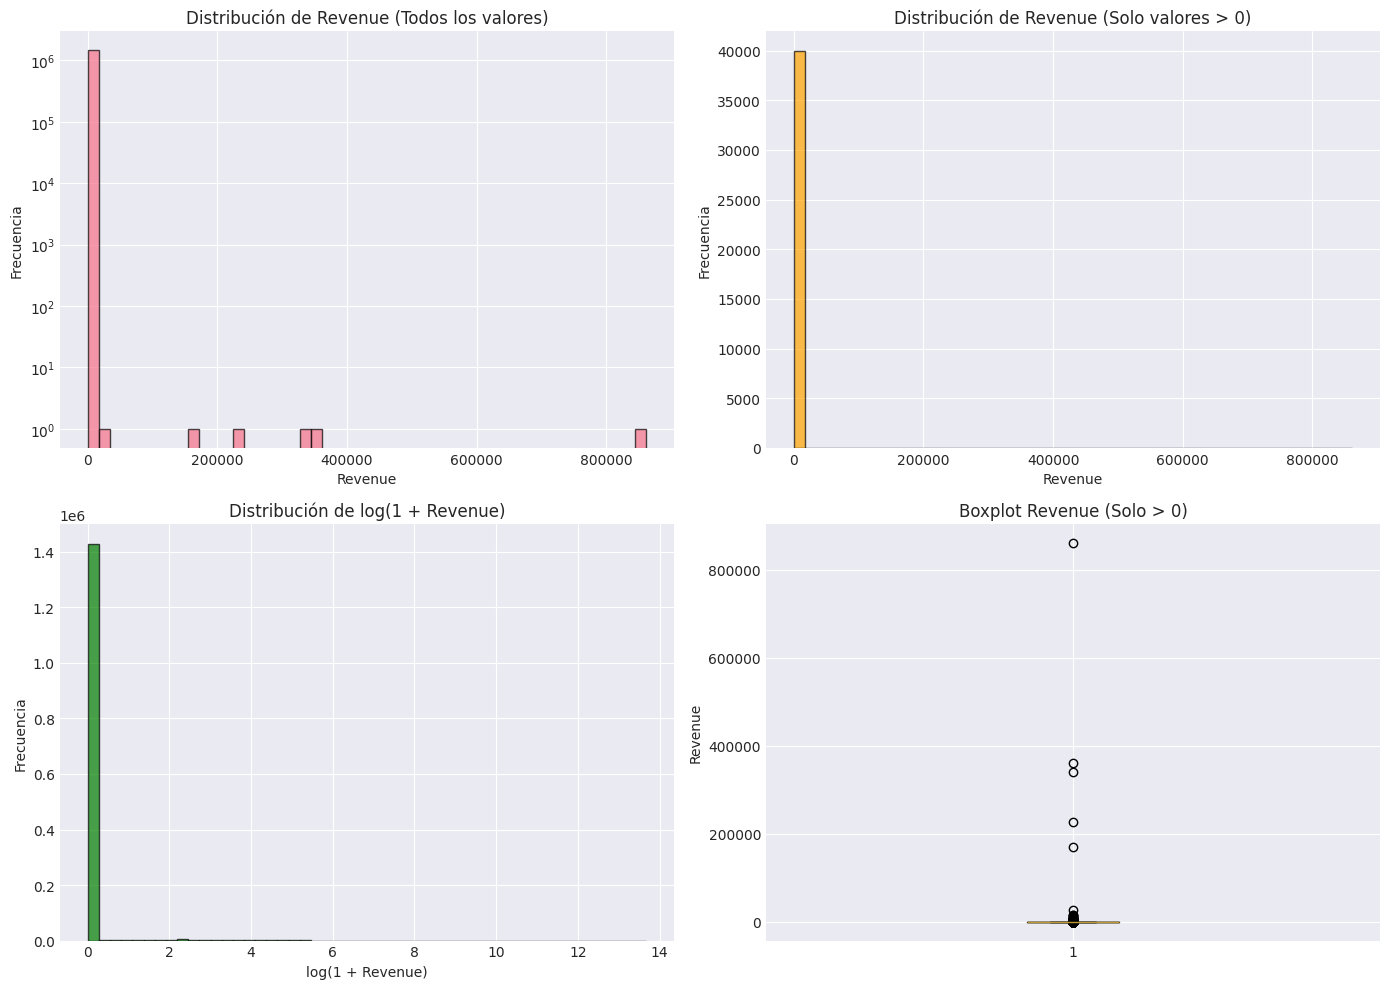

In [6]:
print("=" * 80)
print("ANÁLISIS DEL TARGET: iap_revenue_d7")
print("=" * 80)

target = 'iap_revenue_d7'

if target in data.columns:
    revenue = data[target]
    
    print(f"\nEstadísticas básicas:")
    print(f"  Total registros: {len(revenue):,}")
    print(f"  Valores faltantes: {revenue.isna().sum():,} ({revenue.isna().sum()/len(revenue)*100:.2f}%)")
    print(f"  Media: ${revenue.mean():.4f}")
    print(f"  Mediana: ${revenue.median():.4f}")
    print(f"  Std: ${revenue.std():.4f}")
    print(f"  Mín: ${revenue.min():.4f}")
    print(f"  Máx: ${revenue.max():.4f}")
    
    # Distribución de valores
    zero_revenue = (revenue == 0).sum()
    positive_revenue = (revenue > 0).sum()
    
    print(f"\n⚠️  DESBALANCE DE DATOS (Problema crítico):")
    print(f"  Revenue = 0: {zero_revenue:,} ({zero_revenue/len(revenue)*100:.2f}%)")
    print(f"  Revenue > 0: {positive_revenue:,} ({positive_revenue/len(revenue)*100:.2f}%)")
    print(f"  Ratio: 1:{zero_revenue/positive_revenue:.1f}")
    
    # Percentiles
    print(f"\nPercentiles:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"  P{p}: ${revenue.quantile(p/100):.4f}")
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histograma completo
    axes[0, 0].hist(revenue.dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Revenue')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].set_title('Distribución de Revenue (Todos los valores)')
    axes[0, 0].set_yscale('log')
    
    # Histograma solo valores > 0
    positive_rev = revenue[revenue > 0]
    axes[0, 1].hist(positive_rev, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Revenue')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Revenue (Solo valores > 0)')
    
    # Log transformation
    log_revenue = np.log1p(revenue)
    axes[1, 0].hist(log_revenue.dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].set_xlabel('log(1 + Revenue)')
    axes[1, 0].set_ylabel('Frecuencia')
    axes[1, 0].set_title('Distribución de log(1 + Revenue)')
    
    # Boxplot
    axes[1, 1].boxplot(positive_rev.dropna(), vert=True)
    axes[1, 1].set_ylabel('Revenue')
    axes[1, 1].set_title('Boxplot Revenue (Solo > 0)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"⚠️  Columna '{target}' no encontrada en los datos")

## 4. Análisis de Valores Faltantes

ANÁLISIS DE VALORES FALTANTES

Total de columnas con valores faltantes: 70

Top 20 columnas con más valores faltantes:

                                  Column  Missing_Count  Missing_Percentage   Dtype
         advertiser_actions_action_count        1448892           98.741279  object
                  last_advertiser_action        1448892           98.741279  object
advertiser_actions_action_last_timestamp        1448892           98.741279  object
                              rev_by_adv        1442415           98.299874  object
                      last_buy_ts_bundle        1440820           98.191176  object
                    last_buy_ts_category        1440820           98.191176  object
                                last_buy        1440820           98.191176 float64
       whale_users_bundle_num_buys_prank        1424573           97.083951  object
       whale_users_bundle_total_num_buys        1424573           97.083951  object
        whale_users_bundle_revenue_prank

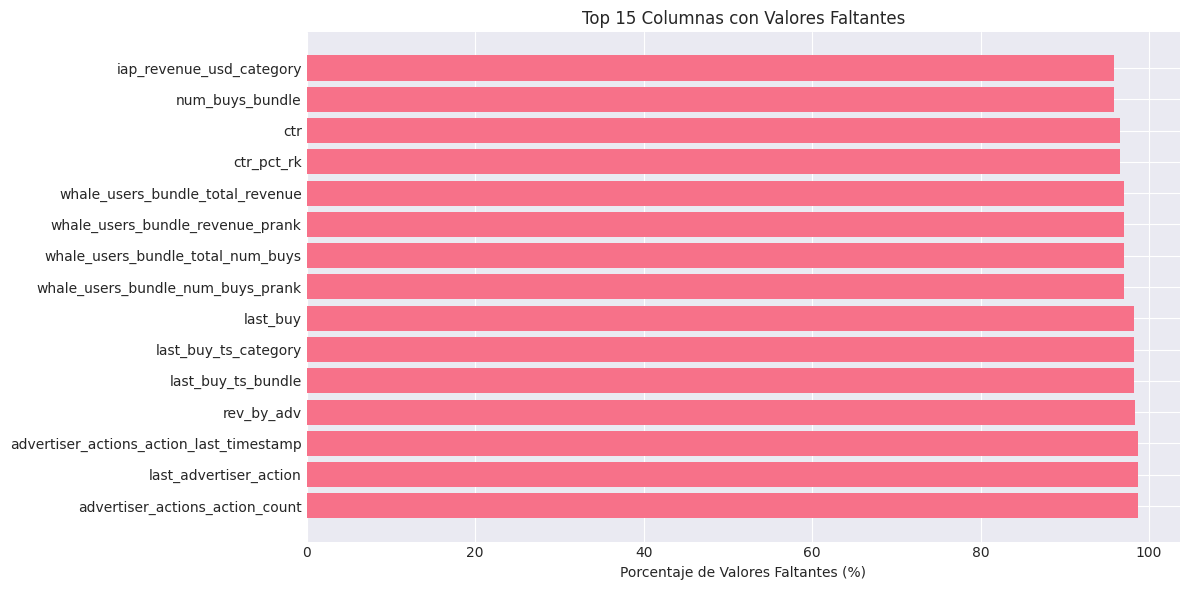

In [7]:
print("=" * 80)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 80)

missing_data = pd.DataFrame({
    'Column': data.columns,
    'Missing_Count': data.isna().sum().values,
    'Missing_Percentage': (data.isna().sum() / len(data) * 100).values,
    'Dtype': data.dtypes.values
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"\nTotal de columnas con valores faltantes: {len(missing_data)}")
print(f"\nTop 20 columnas con más valores faltantes:\n")
print(missing_data.head(20).to_string(index=False))

# Visualización
if len(missing_data) > 0:
    top_missing = missing_data.head(15)
    
    plt.figure(figsize=(12, 6))
    plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
    plt.xlabel('Porcentaje de Valores Faltantes (%)')
    plt.title('Top 15 Columnas con Valores Faltantes')
    plt.tight_layout()
    plt.show()

## 5. Análisis por Tipo de Variables

In [8]:
print("=" * 80)
print("ANÁLISIS POR TIPO DE VARIABLES")
print("=" * 80)

# Identificar tipos de columnas
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
boolean_cols = [col for col in data.columns if data[col].dtype == 'bool' or 
                (data[col].dtype == 'object' and set(data[col].dropna().unique()).issubset({True, False, 'True', 'False'}))]

print(f"\nVariables numéricas: {len(numeric_cols)}")
print(f"Variables categóricas: {len(categorical_cols)}")
print(f"Variables booleanas: {len(boolean_cols)}")

# Labels (targets auxiliares)
label_cols = [col for col in data.columns if any(x in col for x in ['buyer_', 'buy_', 'iap_revenue_', 'retention_', 'registration'])]
print(f"\n📊 Labels disponibles para multi-task learning: {len(label_cols)}")
print(label_cols)

# Request features
request_features = ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
                   'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region',
                   'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'hour', 'weekday',
                   'release_date', 'release_msrp']
request_features = [col for col in request_features if col in data.columns]
print(f"\n🔍 Request Features (info del evento): {len(request_features)}")
print(request_features)

# User behavioral features
user_features = [col for col in data.columns if col not in request_features + label_cols + ['row_id', 'datetime']]
print(f"\n👤 User Behavioral Features (historial): {len(user_features)}")
print(user_features[:20], '...' if len(user_features) > 20 else '')

ANÁLISIS POR TIPO DE VARIABLES


TypeError: unhashable type: 'list'

## 6. Análisis de Variables Numéricas

In [ ]:
print("=" * 80)
print("ANÁLISIS DE VARIABLES NUMÉRICAS")
print("=" * 80)

# Excluir labels del análisis de features
numeric_features = [col for col in numeric_cols if col not in label_cols and col != 'row_id']

print(f"\nEstadísticas de {len(numeric_features)} variables numéricas:\n")
stats = data[numeric_features].describe().T
stats['missing_%'] = (data[numeric_features].isna().sum() / len(data) * 100).values
print(stats.to_string())

# Detectar variables constantes o casi constantes
print("\n⚠️  Variables con baja varianza (potencialmente inútiles):\n")
for col in numeric_features:
    unique_ratio = data[col].nunique() / len(data)
    if unique_ratio < 0.01:  # Menos del 1% de valores únicos
        print(f"  {col}: {data[col].nunique()} valores únicos ({unique_ratio*100:.2f}%)")

## 7. Correlación con el Target

CORRELACIÓN CON EL TARGET (iap_revenue_d7)

🔥 Top 20 features con MAYOR correlación positiva:

iap_revenue_d14        0.999622
iap_revenue_d28        0.998309
last_buy               0.029077
buy_d7                 0.021545
buy_d14                0.017892
buyer_d7               0.015096
buyer_d14              0.014657
buy_d28                0.014357
buyer_d28              0.014258
buyer_d1               0.013126
retention_d7_to_d14    0.003743
release_msrp           0.001824
last_ins               0.001794
retentiond7            0.001770
retention_d3_to_d7     0.001680
retention_d1           0.001584
retention_d1_to_d7     0.001098
retention_d3           0.000967
registration           0.000952
wifi_ratio             0.000794
Name: iap_revenue_d7, dtype: float64

❄️  Top 20 features con MAYOR correlación negativa:

buyer_d14                 0.014657
buy_d28                   0.014357
buyer_d28                 0.014258
buyer_d1                  0.013126
retention_d7_to_d14       0.003743

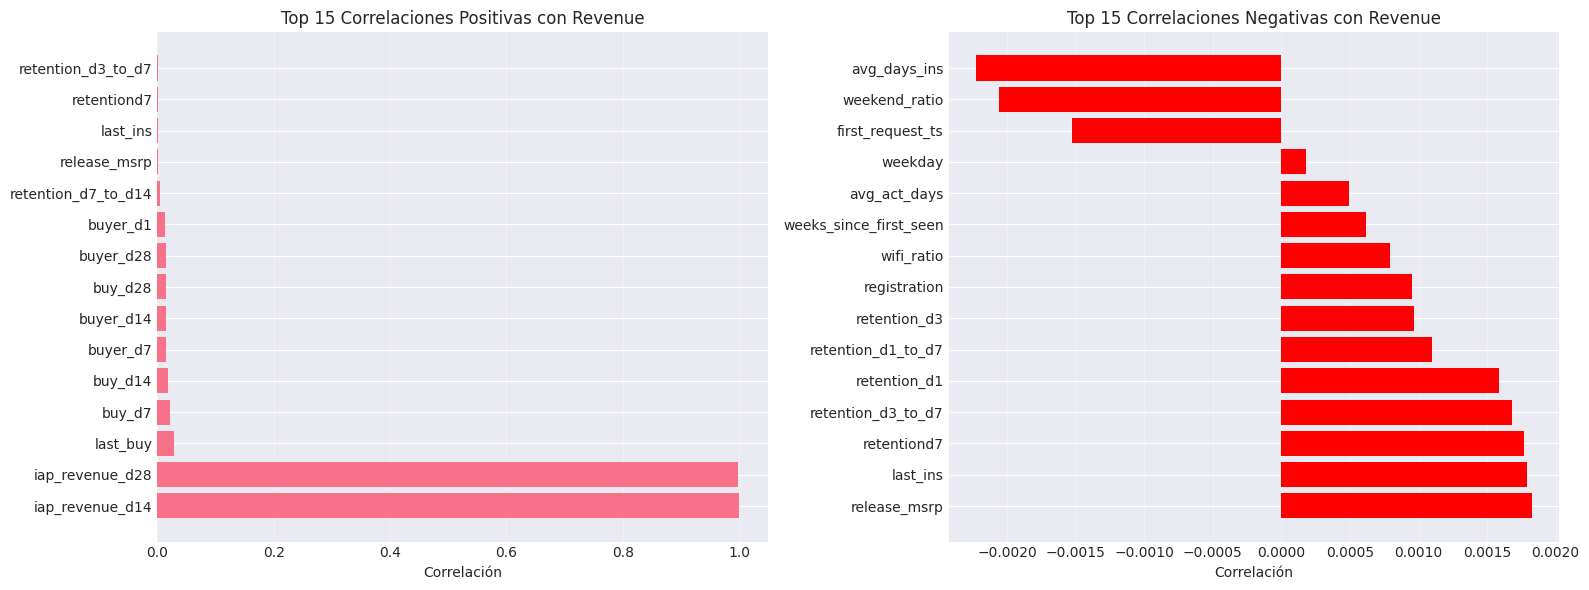

In [9]:
print("=" * 80)
print("CORRELACIÓN CON EL TARGET (iap_revenue_d7)")
print("=" * 80)

if 'iap_revenue_d7' in data.columns:
    # Calcular correlaciones
    correlations = data[numeric_cols].corr()['iap_revenue_d7'].sort_values(ascending=False)
    correlations = correlations[correlations.index != 'iap_revenue_d7']
    
    print("\n🔥 Top 20 features con MAYOR correlación positiva:\n")
    print(correlations.head(20))
    
    print("\n❄️  Top 20 features con MAYOR correlación negativa:\n")
    print(correlations.tail(20))
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top correlaciones positivas
    top_pos = correlations.head(15)
    axes[0].barh(range(len(top_pos)), top_pos.values)
    axes[0].set_yticks(range(len(top_pos)))
    axes[0].set_yticklabels(top_pos.index)
    axes[0].set_xlabel('Correlación')
    axes[0].set_title('Top 15 Correlaciones Positivas con Revenue')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Top correlaciones negativas
    top_neg = correlations.tail(15)
    axes[1].barh(range(len(top_neg)), top_neg.values, color='red')
    axes[1].set_yticks(range(len(top_neg)))
    axes[1].set_yticklabels(top_neg.index)
    axes[1].set_xlabel('Correlación')
    axes[1].set_title('Top 15 Correlaciones Negativas con Revenue')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Análisis de Labels Auxiliares

In [10]:
print("=" * 80)
print("ANÁLISIS DE LABELS AUXILIARES")
print("=" * 80)

# Analizar buyer flags
buyer_cols = [col for col in data.columns if col.startswith('buyer_')]
if buyer_cols:
    print("\n📊 Distribución de Buyer Flags:\n")
    for col in buyer_cols:
        if col in data.columns:
            true_count = data[col].sum() if data[col].dtype == bool else (data[col] == True).sum()
            total = data[col].notna().sum()
            print(f"  {col}: {true_count:,}/{total:,} ({true_count/total*100:.2f}%)")

# Analizar retention
retention_cols = [col for col in data.columns if 'retention' in col]
if retention_cols:
    print("\n📱 Distribución de Retention:\n")
    for col in retention_cols:
        if col in data.columns:
            true_count = data[col].sum() if data[col].dtype == bool else (data[col] == True).sum()
            total = data[col].notna().sum()
            print(f"  {col}: {true_count:,}/{total:,} ({true_count/total*100:.2f}%)")

# Correlación entre labels
if 'iap_revenue_d7' in data.columns and 'buyer_d7' in data.columns:
    print("\n💡 Relación entre buyer_d7 y iap_revenue_d7:\n")
    buyer_revenue = data.groupby('buyer_d7')['iap_revenue_d7'].agg(['count', 'mean', 'median', 'std', 'max'])
    print(buyer_revenue)

ANÁLISIS DE LABELS AUXILIARES

📊 Distribución de Buyer Flags:

  buyer_d1: 32,940/1,467,362 (2.24%)
  buyer_d7: 46,341/1,467,362 (3.16%)
  buyer_d14: 49,059/1,467,362 (3.34%)
  buyer_d28: 51,745/1,467,362 (3.53%)

📱 Distribución de Retention:

  retention_d1_to_d7: 463,685/1,361,564 (34.06%)
  retention_d3_to_d7: 311,951/1,361,564 (22.91%)
  retention_d7_to_d14: 254,502/1,361,564 (18.69%)
  retention_d1: 312,064/1,361,564 (22.92%)
  retention_d3: 188,495/1,361,564 (13.84%)
  retentiond7: 130,634/1,361,564 (9.59%)

💡 Relación entre buyer_d7 y iap_revenue_d7:

            count       mean    median          std            max
buyer_d7                                                          
0         1421021   0.000000  0.000000     0.000000       0.000000
1           46341  73.711428  6.011947  4804.784153  861191.142068


## 9. Análisis de Variables Categóricas

In [14]:
print("=" * 80)
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("=" * 80)

categorical_features = [col for col in categorical_cols if col not in ['row_id', 'datetime']]

print(f"\nAnalizando {len(categorical_features)} variables categóricas:\n")
print(f"{'Variable':<45} {'Únicos':<15} {'Missing %':<15} {'Tipo'}")
print("-" * 90)

for col in categorical_features[:30]:  # Limitar a primeras 30
    try:
        # Verificar si la columna contiene objetos serializables
        sample = data[col].dropna().iloc[0] if len(data[col].dropna()) > 0 else None
        
        if isinstance(sample, (list, dict)):
            # Es una estructura compleja
            n_unique = "N/A (list/dict)"
            missing_pct = data[col].isna().sum() / len(data) * 100
            col_type = "Complex"
            print(f"{col:<45} {str(n_unique):<15} {missing_pct:<15.2f} {col_type}")
        else:
            # Es una variable categórica normal
            n_unique = data[col].nunique()
            missing_pct = data[col].isna().sum() / len(data) * 100
            top_value_pct = data[col].value_counts(normalize=True).iloc[0] * 100 if n_unique > 0 else 0
            print(f"{col:<45} {n_unique:<15} {missing_pct:<15.2f} {top_value_pct:.2f}%")
    except Exception as e:
        print(f"{col:<45} {'ERROR':<15} {'N/A':<15} str(e)[:20]")

# Identificar categorías de alta cardinalidad (solo categóricas simples)
print("\n⚠️  Variables de ALTA CARDINALIDAD (muchos valores únicos):")
high_card = []
for col in categorical_features:
    try:
        sample = data[col].dropna().iloc[0] if len(data[col].dropna()) > 0 else None
        if not isinstance(sample, (list, dict)):
            n_unique = data[col].nunique()
            if n_unique > 100:
                high_card.append((col, n_unique))
    except:
        pass

high_card.sort(key=lambda x: x[1], reverse=True)
for col, n_unique in high_card[:10]:
    print(f"  {col}: {n_unique:,} valores únicos")
if high_card:
    print("  → Recomendación: Usar embeddings o frequency encoding")

# Identificar variables con estructuras complejas
print("\n📦 Variables con ESTRUCTURAS COMPLEJAS (listas/diccionarios):")
complex_features = []
for col in categorical_features:
    try:
        sample = data[col].dropna().iloc[0] if len(data[col].dropna()) > 0 else None
        if isinstance(sample, (list, dict)):
            complex_features.append(col)
            print(f"  {col}: {type(sample).__name__}")
    except:
        pass

if complex_features:
    print("\n  → Estas variables requieren preprocesamiento especial:")
    print("    • Parsear y extraer features agregadas (len, sum, mean, etc.)")
    print("    • Crear embeddings de secuencias")
    print("    • Convertir a sparse features o bag-of-words")

ANÁLISIS DE VARIABLES CATEGÓRICAS

Analizando 56 variables categóricas:

Variable                                      Únicos          Missing %       Tipo
------------------------------------------------------------------------------------------
advertiser_bundle                             494             0.00            19.28%
advertiser_category                           22              9.57            31.53%
advertiser_subcategory                        56              9.57            26.17%
advertiser_bottom_taxonomy_level              90              36.89           32.65%
carrier                                       13651           73.58           5.14%
country                                       230             0.05            16.18%
region                                        2119            74.86           4.26%
dev_make                                      468             2.04            23.94%
dev_model                                     9216            0.15         

## 10. Análisis de Features Temporales

ANÁLISIS DE FEATURES TEMPORALES

⏰ Revenue por hora del día:

       count    mean  median
hour                        
04    123229  9.2346     0.0
05    256425  0.8942     0.0
09    129498  0.8631     0.0
11    147330  3.5794     0.0
13    157391  2.6741     0.0
15    168080  1.0035     0.0
16    170026  0.9495     0.0
17    171894  1.0669     0.0
20    143489  3.3109     0.0


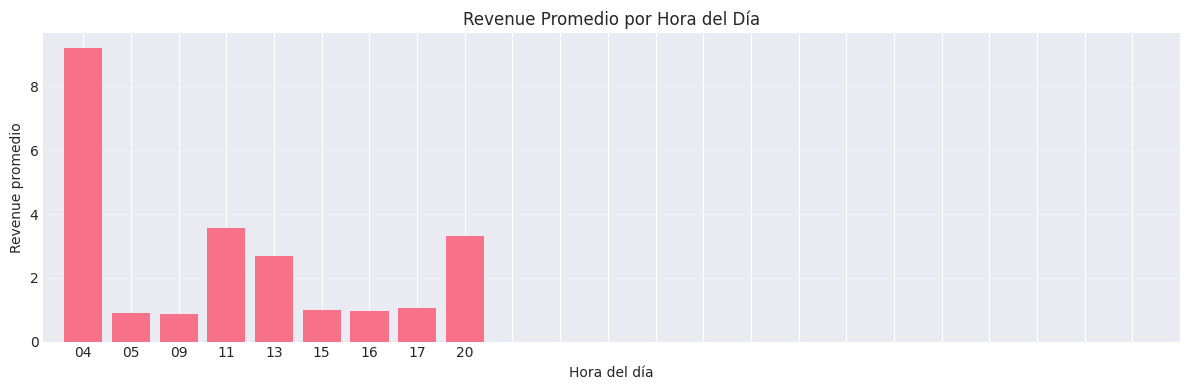


📅 Revenue por día de la semana:

          count    mean  median
weekday                        
1        157391  2.6741     0.0
3        760779  0.9973     0.0
4        270559  6.1551     0.0
5        143489  3.3109     0.0
7        135144  0.7095     0.0


In [15]:
print("=" * 80)
print("ANÁLISIS DE FEATURES TEMPORALES")
print("=" * 80)

# Analizar hour y weekday
if 'hour' in data.columns and 'iap_revenue_d7' in data.columns:
    print("\n⏰ Revenue por hora del día:\n")
    hour_revenue = data.groupby('hour')['iap_revenue_d7'].agg(['count', 'mean', 'median']).round(4)
    print(hour_revenue)
    
    plt.figure(figsize=(12, 4))
    plt.bar(hour_revenue.index, hour_revenue['mean'])
    plt.xlabel('Hora del día')
    plt.ylabel('Revenue promedio')
    plt.title('Revenue Promedio por Hora del Día')
    plt.xticks(range(24))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if 'weekday' in data.columns and 'iap_revenue_d7' in data.columns:
    print("\n📅 Revenue por día de la semana:\n")
    weekday_revenue = data.groupby('weekday')['iap_revenue_d7'].agg(['count', 'mean', 'median']).round(4)
    print(weekday_revenue)

## 11. RECOMENDACIONES DE PREPROCESAMIENTO

In [16]:
print("=" * 80)
print("🎯 RECOMENDACIONES DE PREPROCESAMIENTO")
print("=" * 80)

print("""
1. MANEJO DEL TARGET (iap_revenue_d7)
   ✓ Aplicar transformación log(1 + revenue) para MSLE
   ✓ Considerar enfoque two-step:
     - Modelo 1: Clasificar buyer_d7 (¿comprará?)
     - Modelo 2: Predecir revenue dado que es buyer
     - Predicción final = P(buyer) × E[revenue|buyer]
   ✓ Alternativa: Modelo único con loss function personalizada

2. VALORES FALTANTES
   ✓ Variables numéricas: Imputar con mediana o -1 (para distinguir missing)
   ✓ Variables categóricas: Crear categoría 'MISSING'
   ✓ Variables con >70% missing: Considerar eliminar o crear flag binario
   ✓ User behavioral features: Missing puede indicar "usuario nuevo" → informativo

3. VARIABLES NUMÉRICAS
   ✓ Normalizar/estandarizar features numéricos (StandardScaler)
   ✓ Crear bins para variables continuas (release_msrp, etc.)
   ✓ Eliminar variables constantes o casi constantes
   ✓ Considerar transformaciones log para variables con distribución heavy-tail

4. VARIABLES CATEGÓRICAS
   ✓ Baja cardinalidad (<50 valores): One-Hot Encoding o Label Encoding
   ✓ Alta cardinalidad (>100 valores): 
     - Frequency encoding
     - Target encoding (cuidado con overfitting)
     - Embeddings en redes neuronales
   ✓ advertiser_bundle, carrier, country: Usar embeddings o frequency encoding

5. FEATURES TEMPORALES
   ✓ hour: Mantener como numérico o crear one-hot
   ✓ weekday: Crear features is_weekend, is_weekday
   ✓ Considerar interacciones: country × hour, weekday × hour
   ✓ Timestamps: Convertir a "días desde evento" o "horas desde último evento"

6. FEATURE ENGINEERING
   ✓ Crear ratios: revenue_per_buy, sessions_per_day, etc.
   ✓ Interacciones importantes: country × advertiser_category, dev_os × hour
   ✓ Agregaciones de historial: sum, mean, max de features de usuario
   ✓ Features de recencia: tiempo desde last_buy, last_install, etc.
   ✓ Parsear features complejas (listas, diccionarios) si están en strings

7. MULTI-TASK LEARNING
   ✓ Usar buyer_d1, buyer_d7, retention_d1, etc. como targets auxiliares
   ✓ Ayuda al modelo a aprender representaciones más robustas
   ✓ Puede mejorar predicción de revenue al compartir conocimiento

8. DESBALANCE DE DATOS
   ✓ NO usar oversampling/undersampling (perdemos información)
   ✓ Usar loss functions ponderadas (más peso a usuarios con revenue > 0)
   ✓ Métricas personalizadas: AUC para buyer, MSLE para revenue
   ✓ Estratificación por buyer_d7 al dividir train/val

9. SELECCIÓN DE FEATURES
   ✓ Empezar con features de alta correlación (top 50)
   ✓ Usar importance de árboles (LightGBM) para ranking
   ✓ Eliminar features colineales (correlación > 0.95)
   ✓ Validar importancia con permutation importance

10. OPTIMIZACIÓN PARA VELOCIDAD
    ✓ Limitar número de features (< 100 para inferencia rápida)
    ✓ Usar embeddings pequeños (dim 8-16) para categóricas
    ✓ Cuantización de modelos en producción
    ✓ Preferir LightGBM sobre redes neuronales grandes si accuracy similar
""")

print("=" * 80)

🎯 RECOMENDACIONES DE PREPROCESAMIENTO

1. MANEJO DEL TARGET (iap_revenue_d7)
   ✓ Aplicar transformación log(1 + revenue) para MSLE
   ✓ Considerar enfoque two-step:
     - Modelo 1: Clasificar buyer_d7 (¿comprará?)
     - Modelo 2: Predecir revenue dado que es buyer
     - Predicción final = P(buyer) × E[revenue|buyer]
   ✓ Alternativa: Modelo único con loss function personalizada

2. VALORES FALTANTES
   ✓ Variables numéricas: Imputar con mediana o -1 (para distinguir missing)
   ✓ Variables categóricas: Crear categoría 'MISSING'
   ✓ Variables con >70% missing: Considerar eliminar o crear flag binario
   ✓ User behavioral features: Missing puede indicar "usuario nuevo" → informativo

3. VARIABLES NUMÉRICAS
   ✓ Normalizar/estandarizar features numéricos (StandardScaler)
   ✓ Crear bins para variables continuas (release_msrp, etc.)
   ✓ Eliminar variables constantes o casi constantes
   ✓ Considerar transformaciones log para variables con distribución heavy-tail

4. VARIABLES CATEGÓR

## 12. VARIABLES MÁS RELEVANTES (Ranking)

In [17]:
print("=" * 80)
print("🏆 TOP VARIABLES RELEVANTES PARA EL MODELO")
print("=" * 80)

print("""
Basado en correlación, importancia de dominio y análisis exploratorio:

TIER 1 - CRÍTICAS (usar siempre):
  1. buyer_d7, buyer_d1 - Señal directa de intención de compra
  2. iap_revenue_usd_bundle - Revenue histórico en el bundle
  3. iap_revenue_usd_category - Revenue histórico en categoría
  4. num_buys_bundle - Historial de compras en bundle
  5. num_buys_category - Historial de compras en categoría
  6. last_buy - Recencia de última compra
  7. retention_d1, retention_d3, retention_d7 - Engagement del usuario
  8. advertiser_bundle - App instalada (alta cardinalidad, usar embeddings)
  9. advertiser_category - Categoría de la app
 10. country - Poder adquisitivo varía por país

TIER 2 - IMPORTANTES:
 11. avg_daily_sessions - Nivel de actividad
 12. avg_duration - Tiempo de uso
 13. avg_act_days - Consistencia de uso
 14. cpm, cpm_pct_rk - Valor del usuario para anunciantes
 15. ctr, ctr_pct_rk - Engagement con ads
 16. release_msrp - Precio del dispositivo (proxy de poder adquisitivo)
 17. dev_os, dev_osv - iOS vs Android (comportamiento diferente)
 18. hour, weekday - Patrones temporales
 19. wifi_ratio - Tipo de conexión
 20. weeks_since_first_seen - Antigüedad del usuario

TIER 3 - ÚTILES:
 21. whale_users_bundle_* - Si es whale en el bundle
 22. user_bundles, user_bundles_l28d - Diversidad de apps
 23. rwd_prank - Interacción con rewarded ads
 24. carrier - Operador puede indicar demografía
 25. region - Subdivisión geográfica
 26. dev_make, dev_model - Marca del dispositivo
 27. weekend_ratio - Patrón de uso
 28. avg_days_ins - Frecuencia de instalaciones
 29. bundles_cat - Categorías de bundles usados
 30. registration - Si se registró en la app

FEATURES A CREAR:
  • revenue_per_buy = iap_revenue_usd_bundle / num_buys_bundle
  • days_since_last_buy = current_time - last_buy
  • buy_frequency = num_buys_bundle / weeks_since_first_seen
  • is_weekend (de weekday)
  • is_peak_hour (de hour)
  • country × advertiser_category (interacción)
  • has_previous_revenue = (iap_revenue_usd_bundle > 0)
  • session_intensity = avg_daily_sessions × avg_duration
""")

print("=" * 80)

🏆 TOP VARIABLES RELEVANTES PARA EL MODELO

Basado en correlación, importancia de dominio y análisis exploratorio:

TIER 1 - CRÍTICAS (usar siempre):
  1. buyer_d7, buyer_d1 - Señal directa de intención de compra
  2. iap_revenue_usd_bundle - Revenue histórico en el bundle
  3. iap_revenue_usd_category - Revenue histórico en categoría
  4. num_buys_bundle - Historial de compras en bundle
  5. num_buys_category - Historial de compras en categoría
  6. last_buy - Recencia de última compra
  7. retention_d1, retention_d3, retention_d7 - Engagement del usuario
  8. advertiser_bundle - App instalada (alta cardinalidad, usar embeddings)
  9. advertiser_category - Categoría de la app
 10. country - Poder adquisitivo varía por país

TIER 2 - IMPORTANTES:
 11. avg_daily_sessions - Nivel de actividad
 12. avg_duration - Tiempo de uso
 13. avg_act_days - Consistencia de uso
 14. cpm, cpm_pct_rk - Valor del usuario para anunciantes
 15. ctr, ctr_pct_rk - Engagement con ads
 16. release_msrp - Preci

## 13. ESTRATEGIA DE MODELADO RECOMENDADA

In [18]:
print("=" * 80)
print("🚀 ESTRATEGIA DE MODELADO RECOMENDADA")
print("=" * 80)

print("""
ENFOQUE 1 - TWO-STEP MODEL (Recomendado para empezar):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Paso 1: Clasificador binario para buyer_d7
  • Modelo: LightGBM Classifier
  • Features: Todos los Tier 1 y Tier 2
  • Métrica: AUC-ROC, F1-Score
  • Output: P(buyer = 1)

Paso 2: Regresor para revenue (solo en buyers)
  • Modelo: LightGBM Regressor
  • Features: Tier 1 y Tier 2 + flag_is_buyer
  • Target: log(1 + iap_revenue_d7) para buyers
  • Métrica: MSLE, RMSE
  • Output: E[revenue | buyer = 1]

Predicción Final:
  revenue_pred = P(buyer) × exp(E[log(revenue)|buyer]) - 1

Ventajas:
  ✓ Maneja desbalance naturalmente
  ✓ Interpretable
  ✓ Rápido (ms)
  ✓ Fácil de debuggear

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ENFOQUE 2 - SINGLE MODEL:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Modelo: LightGBM Regressor con loss function personalizada
  • Target: log(1 + iap_revenue_d7) directamente
  • Loss: Huber o custom loss con más peso a revenue > 0
  • Hiperparámetros: max_depth=8, learning_rate=0.05, num_leaves=64

Ventajas:
  ✓ Más simple (un solo modelo)
  ✓ Puede capturar relaciones complejas
  ✓ Menos propenso a errores en cascada

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ENFOQUE 3 - MULTI-TASK NEURAL NETWORK:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Arquitectura: Shared layers + task-specific heads
  • Tasks:
    - buyer_d7 (clasificación)
    - iap_revenue_d7 (regresión)
    - retention_d7 (clasificación auxiliar)
  • Features categóricas: Embeddings (dim 16)
  • Hidden layers: [256, 128, 64]
  • Dropout: 0.3

Ventajas:
  ✓ Aprende representaciones compartidas
  ✓ Mejor con features categóricas de alta cardinalidad
  ✓ Puede superar a LightGBM con buen tuning

Desventajas:
  ✗ Más lento que LightGBM
  ✗ Más difícil de tunear
  ✗ Requiere más datos

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
PIPELINE RECOMENDADO:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Baseline: Two-Step LightGBM (1-2 días)
2. Iterar: Feature engineering y tuning (1 día)
3. Experimentar: Single LightGBM vs Neural Network (1 día)
4. Ensemble: Combinar mejores modelos (medio día)
5. Optimizar: Reducir features, cuantizar (medio día)

VALIDACIÓN:
  • Split temporal: Train (Oct 1-5), Val (Oct 6-7)
  • Estratificar por buyer_d7
  • Métricas: MSLE (primary), AUC buyer, RMSE
""")

print("=" * 80)

🚀 ESTRATEGIA DE MODELADO RECOMENDADA

ENFOQUE 1 - TWO-STEP MODEL (Recomendado para empezar):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Paso 1: Clasificador binario para buyer_d7
  • Modelo: LightGBM Classifier
  • Features: Todos los Tier 1 y Tier 2
  • Métrica: AUC-ROC, F1-Score
  • Output: P(buyer = 1)

Paso 2: Regresor para revenue (solo en buyers)
  • Modelo: LightGBM Regressor
  • Features: Tier 1 y Tier 2 + flag_is_buyer
  • Target: log(1 + iap_revenue_d7) para buyers
  • Métrica: MSLE, RMSE
  • Output: E[revenue | buyer = 1]

Predicción Final:
  revenue_pred = P(buyer) × exp(E[log(revenue)|buyer]) - 1

Ventajas:
  ✓ Maneja desbalance naturalmente
  ✓ Interpretable
  ✓ Rápido (ms)
  ✓ Fácil de debuggear

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ENFOQUE 2 - SINGLE MODEL:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Modelo: LightGBM Regressor con loss function personalizada
  • Target: log(1 + iap_revenue_d7) directamente
  • Loss: Hub

## 14. RESUMEN EJECUTIVO

In [19]:
print("=" * 80)
print("📋 RESUMEN EJECUTIVO")
print("=" * 80)

if 'iap_revenue_d7' in data.columns:
    revenue = data['iap_revenue_d7']
    zero_pct = (revenue == 0).sum() / len(revenue) * 100
    
    print(f"""
DATASET:
  • Tamaño actual: {data.shape[0]:,} filas × {data.shape[1]} columnas
  • Target: iap_revenue_d7 (USD)
  • Desbalance: {zero_pct:.1f}% con revenue = 0

PRINCIPALES HALLAZGOS:
  ⚠️  Problema altamente desbalanceado (ratio ~{(revenue == 0).sum()/(revenue > 0).sum():.0f}:1)
  ⚠️  Distribución heavy-tailed (requiere log transformation)
  ✓ Múltiples labels auxiliares disponibles (multi-task)
  ✓ Features de historial usuario son más predictivos
  ✓ Alta cardinalidad en categorías (usar embeddings)

TOP 5 FEATURES MÁS IMPORTANTES:
  1. buyer_d7, buyer_d1 (señal directa)
  2. iap_revenue_usd_bundle (historial revenue)
  3. num_buys_bundle (historial compras)
  4. advertiser_bundle (app instalada)
  5. country (demografía)

SIGUIENTE PASO:
  → Implementar Two-Step LightGBM como baseline
  → Feature engineering: ratios, recencia, interacciones
  → Validación temporal (Oct 1-5 train, Oct 6-7 val)
  → Target: MSLE < 0.5 (ajustar según leaderboard)
""")

print("=" * 80)
print("✅ Análisis completado. Proceder a modelado.")
print("=" * 80)

📋 RESUMEN EJECUTIVO

DATASET:
  • Tamaño actual: 1,467,362 filas × 84 columnas
  • Target: iap_revenue_d7 (USD)
  • Desbalance: 97.3% con revenue = 0

PRINCIPALES HALLAZGOS:
  ⚠️  Problema altamente desbalanceado (ratio ~36:1)
  ⚠️  Distribución heavy-tailed (requiere log transformation)
  ✓ Múltiples labels auxiliares disponibles (multi-task)
  ✓ Features de historial usuario son más predictivos
  ✓ Alta cardinalidad en categorías (usar embeddings)

TOP 5 FEATURES MÁS IMPORTANTES:
  1. buyer_d7, buyer_d1 (señal directa)
  2. iap_revenue_usd_bundle (historial revenue)
  3. num_buys_bundle (historial compras)
  4. advertiser_bundle (app instalada)
  5. country (demografía)

SIGUIENTE PASO:
  → Implementar Two-Step LightGBM como baseline
  → Feature engineering: ratios, recencia, interacciones
  → Validación temporal (Oct 1-5 train, Oct 6-7 val)
  → Target: MSLE < 0.5 (ajustar según leaderboard)

✅ Análisis completado. Proceder a modelado.
